In [480]:
ES_URL = "http://192.168.122.3:9200"
ES_INDEX = "logs-endpoint-winevent-security-*"
FILTER = {'winlog.task':":Logon"}

In [481]:
# imports
import pandas as pd
from elasticsearch import Elasticsearch  
from elasticsearch_dsl import Search
import mlflow
import mlflow.pyfunc

import fbprophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics


import functools
import csv
from os.path import isfile as isfile
import hashlib

class FbProphetWrapper(mlflow.pyfunc.PythonModel):

    def __init__(self, model):
        self.model = model
        super(FbProphetWrapper, self).__init__()


    def load_context(self, context):
        from fbprophet import Prophet
        return

    def predict(self, context, model_input):
        prediction = self.model.predict(model_input)
        actual = model_input["y"]
        
        merged = pd.concat([prediction, actual], axis=1)
        
        merged["outlier"] = \
            (merged.y < merged.yhat_lower) | (merged.y > merged.yhat_upper)
        
        merged["anomaly_score"] = (
            np.maximum((merged.yhat-merged.y) / abs(merged.yhat_lower-merged.yhat),
                       (merged.y-merged.yhat) / abs(merged.yhat_upper-merged.yhat))
        )
        
        
        merged = merged.astype({"outlier": int, "anomaly_score": float}) 
        
        return merged[["outlier","anomaly_score"]].values.tolist()
    
def get_data(elast_url, index, limit=-1):  
        
        def save_to_csv(elast_url, index, file_name):
            
            print("saving to csv as file did not exist")
            es = Elasticsearch(elast_url,timeout=600)
            s = Search(using=es, index=ES_INDEX)[:0]
            s = s.filter('match', **FILTER)
            s.aggs.bucket(
                'events_per_day', 
                'date_histogram', 
                field='@timestamp', 
                calendar_interval='day')
            resp = s.execute()
            
            with open(file_name, mode='w') as es_fd:
                writer = csv.DictWriter(es_fd, fieldnames=["ds", "y"])
                writer.writeheader()
                for hit in resp.aggregations.events_per_day:          
                    hit_dict = {
                        # strip UTZ Timezone information
                        "ds": hit.key_as_string[:-5],
                        "y": hit.doc_count
                    }                    
                    writer.writerow(hit_dict)
                    
                    
        def read_from_csv(csv_file):

            data = pd.read_csv(csv_file)
            return data

        file_name_clear = ("{}{}{}"
            .format(
                len(elast_url),
                elast_url,
                len(index),
                index))
                   
        file_name = (str(hashlib.sha1(file_name_clear.encode("UTF-8")).hexdigest()[:10]) + ".csv")
            
        print("filename: {}".format(file_name))
        
        if not isfile(file_name):
            save_to_csv(elast_url,index,file_name)   
        
        data_frame = read_from_csv(file_name)
        
        data_frame = data_frame[:limit]
        
        return data_frame
    

In [482]:
import logging
import warnings
import numpy as np

def train(*params):
    
    # setup logging
    logging.basicConfig(level=logging.WARN)
    logger = logging.getLogger(__name__)
    
    np.random.seed(40)
    
    elast_url = ES_URL
    index = ES_INDEX
    
    data = get_data(elast_url, index, 1000)
    return data
    

In [483]:
data = train()

x_train_pd=data

filename: 9cce6a53c1.csv


In [484]:
m = Prophet()
m.fit(x_train_pd[:800])

mlflow.pyfunc.log_model("model", conda_env="conda_running.yaml", python_model=FbProphetWrapper(m))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [485]:
test = FbProphetWrapper(m)

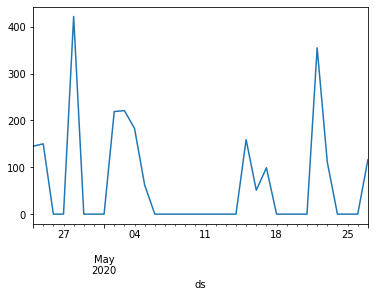

In [486]:
import matplotlib.pyplot as plt
plot_pd = x_train_pd.copy()
plot_pd.ds = pd.to_datetime(plot_pd.ds) # properly convert to datetime type
plot_pd.index = plot_pd.ds # make x-axis naturally appear in the datetime format
plot_pd.y.plot()
plt.show()

In [487]:
future = x_train_pd
forecast = m.predict(future)

In [488]:
actual = future["y"]
merged = pd.concat([forecast, actual], axis=1)

merged["outlier"] = \
    (merged.y < merged.yhat_lower) | (merged.y > merged.yhat_upper)

merged["anomaly_score"] = (
    np.maximum((merged.yhat-merged.y) / abs(merged.yhat_lower-merged.yhat),
               (merged.y-merged.yhat) / abs(merged.yhat_upper-merged.yhat))
)


merged = merged.astype({"outlier": int, "anomaly_score": float}) 

merged[["outlier","anomaly_score"]].values.tolist()

merged

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,outlier,anomaly_score
0,2020-04-24,88.974972,22.596006,273.802936,88.974972,88.974972,62.774935,62.774935,62.774935,62.774935,62.774935,62.774935,0.0,0.0,0.0,151.749907,145,0,0.052263
1,2020-04-25,87.558900,1.683023,249.502339,87.558900,87.558900,38.576941,38.576941,38.576941,38.576941,38.576941,38.576941,0.0,0.0,0.0,126.135841,150,0,0.193441
2,2020-04-26,86.142828,-40.749565,205.004832,86.142828,86.142828,-2.229261,-2.229261,-2.229261,-2.229261,-2.229261,-2.229261,0.0,0.0,0.0,83.913568,0,0,0.673123
3,2020-04-27,84.726756,-69.720166,166.935636,84.726756,84.726756,-28.227811,-28.227811,-28.227811,-28.227811,-28.227811,-28.227811,0.0,0.0,0.0,56.498945,0,0,0.447626
4,2020-04-28,83.310684,-11.925010,242.041572,83.310684,83.310684,33.420193,33.420193,33.420193,33.420193,33.420193,33.420193,0.0,0.0,0.0,116.730877,422,1,2.436098
5,2020-04-29,81.894612,-75.716566,166.152458,81.894612,81.894612,-38.805008,-38.805008,-38.805008,-38.805008,-38.805008,-38.805008,0.0,0.0,0.0,43.089604,0,0,0.362688
6,2020-04-30,80.478540,-102.327484,138.706190,80.478540,80.478540,-65.509990,-65.509990,-65.509990,-65.509990,-65.509990,-65.509990,0.0,0.0,0.0,14.968550,0,0,0.127613
7,2020-05-01,79.062468,19.944807,268.379228,79.062468,79.062468,62.774935,62.774935,62.774935,62.774935,62.774935,62.774935,0.0,0.0,0.0,141.837403,0,1,1.163626
8,2020-05-02,77.646396,-7.150077,236.084456,77.646396,77.646396,38.576941,38.576941,38.576941,38.576941,38.576941,38.576941,0.0,0.0,0.0,116.223337,219,0,0.857465
9,2020-05-03,76.230324,-50.026655,203.109464,76.230324,76.230324,-2.229261,-2.229261,-2.229261,-2.229261,-2.229261,-2.229261,0.0,0.0,0.0,74.001064,221,1,1.138570


In [474]:
import numpy as np

merged[merged.outlier==True]
merged["anomaly_score"] = np.maximum((merged.yhat-merged.y) / abs(merged.yhat_lower-merged.yhat),\
                          (merged.y-merged.yhat) / abs(merged.yhat_upper-merged.yhat))


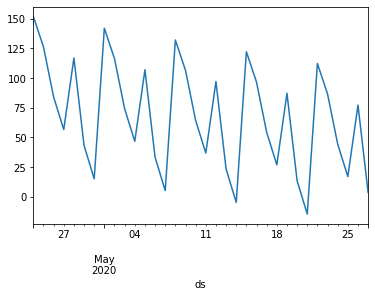

In [475]:
import matplotlib.pyplot as plt
plot_pd = merged.copy()
plot_pd.ds = pd.to_datetime(plot_pd.ds) # properly convert to datetime type
plot_pd.index = plot_pd.ds # make x-axis naturally appear in the datetime format
plot_pd.yhat.plot()
plt.show()

In [426]:
x_train_pd[800:]

,ds,y
800,2010-03-31,7.612831
801,2010-04-01,7.454141
802,2010-04-02,7.367077
803,2010-04-03,7.452982
804,2010-04-04,7.478735
...,...,...
995,2010-10-19,8.718009
996,2010-10-20,8.344743
997,2010-10-21,8.263075
998,2010-10-22,8.256088


In [489]:
type(merged["ds"])

pandas.core.series.Series

In [464]:
merged = merged.astype({"outlier": int, "anomaly_score": float}) 
merged[["outlier","anomaly_score"]].values.tolist()

[[0.0, 0.3176153290053349],
 [0.0, 0.5573522125256137],
 [0.0, 0.7072826314312928],
 [0.0, 0.1488679620587813],
 [0.0, 0.8376032126113896],
 [0.0, 0.39032939885756524],
 [0.0, 0.3466382073834862],
 [0.0, 0.3768403869331363],
 [0.0, 0.5323085810727014],
 [0.0, 0.522795858399277],
 [0.0, 0.4972930612354943],
 [1.0, 1.1116508061888535],
 [1.0, 1.7520213885426712],
 [1.0, 1.096231260404377],
 [1.0, 1.0150036085772376],
 [0.0, 0.7214989530645202],
 [0.0, 0.5926321051052816],
 [0.0, 0.7003246440945968],
 [1.0, 1.3810603866464266],
 [1.0, 1.8471617385539751],
 [1.0, 1.373400155641832],
 [0.0, 0.8110735303785263],
 [0.0, 0.21065746621051887],
 [1.0, 1.5660850909258628],
 [0.0, 0.8785844536009981],
 [0.0, 0.7396763820707383],
 [1.0, 1.2758545217769723],
 [0.0, 0.6048227260129942],
 [0.0, 0.47484042979120306],
 [0.0, 0.5449582446077837],
 [0.0, 0.6341016721519014],
 [0.0, 0.8794364770880055],
 [1.0, 1.2556691638990243],
 [1.0, 1.5517059509687812],
 [1.0, 1.1332304538256859],
 [0.0, 0.97569339074

In [492]:
merged

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,outlier,anomaly_score,ds_dt
0,2020-04-24,88.974972,22.596006,273.802936,88.974972,88.974972,62.774935,62.774935,62.774935,62.774935,62.774935,62.774935,0.0,0.0,0.0,151.749907,145,0,0.052263,2020-04-24
1,2020-04-25,87.558900,1.683023,249.502339,87.558900,87.558900,38.576941,38.576941,38.576941,38.576941,38.576941,38.576941,0.0,0.0,0.0,126.135841,150,0,0.193441,2020-04-25
2,2020-04-26,86.142828,-40.749565,205.004832,86.142828,86.142828,-2.229261,-2.229261,-2.229261,-2.229261,-2.229261,-2.229261,0.0,0.0,0.0,83.913568,0,0,0.673123,2020-04-26
3,2020-04-27,84.726756,-69.720166,166.935636,84.726756,84.726756,-28.227811,-28.227811,-28.227811,-28.227811,-28.227811,-28.227811,0.0,0.0,0.0,56.498945,0,0,0.447626,2020-04-27
4,2020-04-28,83.310684,-11.925010,242.041572,83.310684,83.310684,33.420193,33.420193,33.420193,33.420193,33.420193,33.420193,0.0,0.0,0.0,116.730877,422,1,2.436098,2020-04-28
5,2020-04-29,81.894612,-75.716566,166.152458,81.894612,81.894612,-38.805008,-38.805008,-38.805008,-38.805008,-38.805008,-38.805008,0.0,0.0,0.0,43.089604,0,0,0.362688,2020-04-29
6,2020-04-30,80.478540,-102.327484,138.706190,80.478540,80.478540,-65.509990,-65.509990,-65.509990,-65.509990,-65.509990,-65.509990,0.0,0.0,0.0,14.968550,0,0,0.127613,2020-04-30
7,2020-05-01,79.062468,19.944807,268.379228,79.062468,79.062468,62.774935,62.774935,62.774935,62.774935,62.774935,62.774935,0.0,0.0,0.0,141.837403,0,1,1.163626,2020-05-01
8,2020-05-02,77.646396,-7.150077,236.084456,77.646396,77.646396,38.576941,38.576941,38.576941,38.576941,38.576941,38.576941,0.0,0.0,0.0,116.223337,219,0,0.857465,2020-05-02
9,2020-05-03,76.230324,-50.026655,203.109464,76.230324,76.230324,-2.229261,-2.229261,-2.229261,-2.229261,-2.229261,-2.229261,0.0,0.0,0.0,74.001064,221,1,1.138570,2020-05-03
